
[INTL Forest (univariate lags + month + trend)] Hold-out accuracy
     RMSE: 245.714
      MAE: 204.124
    MAPE%: 5.234
   sMAPE%: 5.439

Forecast results saved to: ../output/Model_01_Forest_TECT_AnnualSpend_international.csv


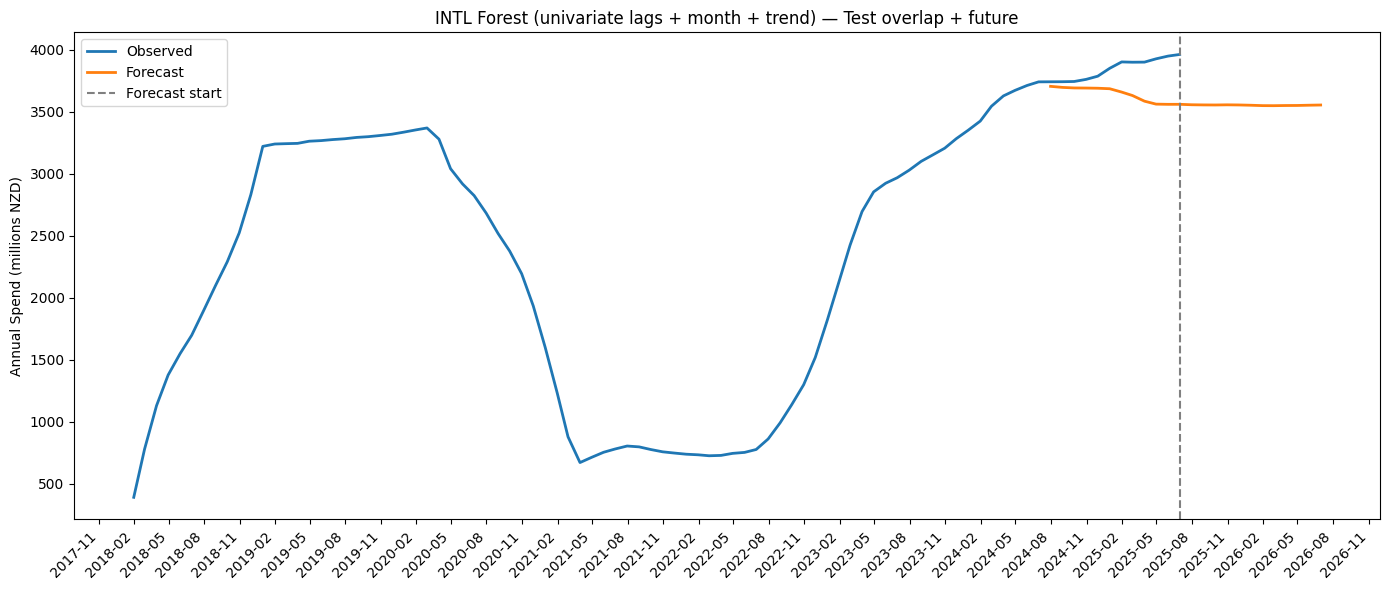


[DOM  Forest (univariate lags + month + trend)] Hold-out accuracy
     RMSE: 383.630
      MAE: 360.133
    MAPE%: 3.225
   sMAPE%: 3.167

Forecast results saved to: ../output/Model_01_Forest_TECT_AnnualSpend_domestic.csv


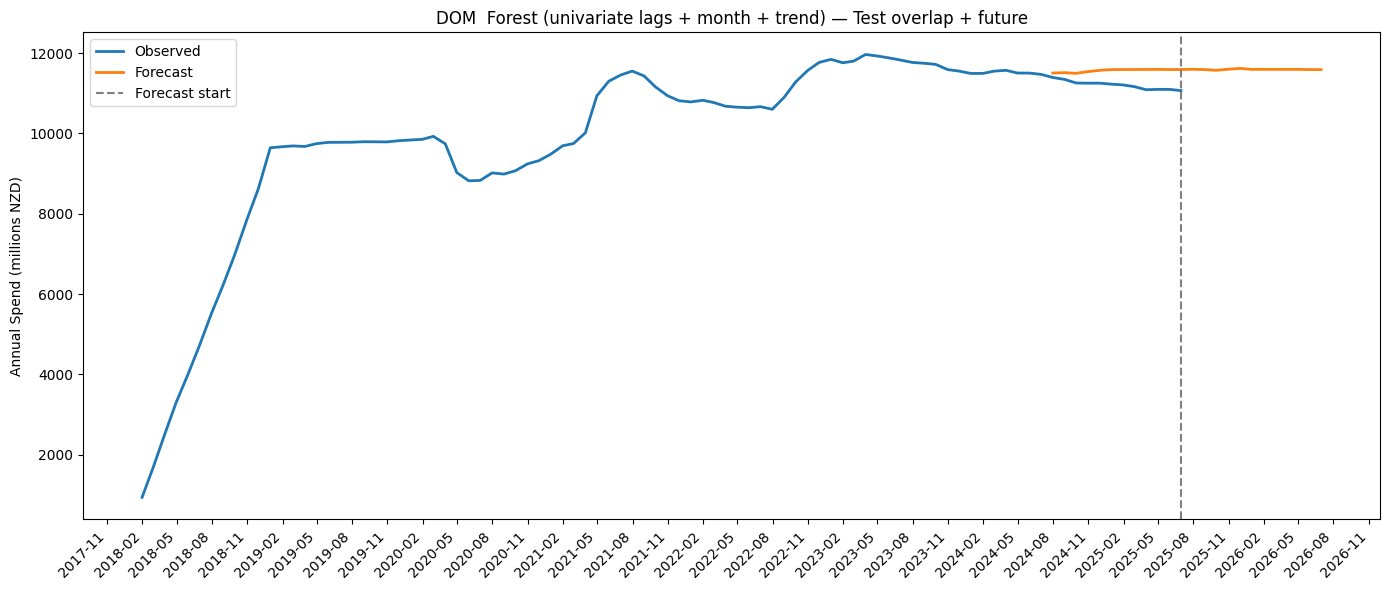

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd

# ML imports from scikit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----------------------- Config -----------------------
TECT_REGION_PATH = "../datasets/TECT/Region-series.csv"
FORECAST_STEPS = 12   # future horizon (after test)
HOLDOUT_STEPS = 12    # test window length

# Forest hyperparams
RF_PARAMS = dict(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# ----------------------- Helpers -----------------------
def _end_of_month_index(s: pd.Series) -> pd.DatetimeIndex:
    return pd.to_datetime(s) + MonthEnd(0)

def _full_month_range(idx: pd.Series) -> pd.DatetimeIndex:
    idx_eom = _end_of_month_index(idx)
    return pd.date_range(start=idx_eom.min(), end=idx_eom.max(), freq="M")

def _configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def _metrics(y_true: pd.Series, y_pred: pd.Series) -> dict:
    y_true, y_pred = y_true.astype(float), y_pred.astype(float)
    err = y_true - y_pred
    rmse = float(np.sqrt(np.mean(err**2)))
    mae = float(np.mean(np.abs(err)))
    denom = y_true.replace(0, np.nan)
    mape = float(np.mean(np.abs(err) / denom) * 100.0)
    smape = float(100.0 * np.mean(2 * np.abs(err) / (np.abs(y_true) + np.abs(y_pred) + 1e-12)))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    print(f"     RMSE: {m['RMSE']:.3f}")
    print(f"      MAE: {m['MAE']:.3f}")
    print(f"    MAPE%: {m['MAPE%']:.3f}" if np.isfinite(m["MAPE%"]) else "    MAPE%: nan")
    print(f"   sMAPE%: {m['sMAPE%']:.3f}" if np.isfinite(m["sMAPE%"]) else "   sMAPE%: nan")

# ----------------------- Data prep -----------------------
def load_data():
    tect = pd.read_csv(TECT_REGION_PATH, parse_dates=["Date"])
    tect["Date"] = tect["Date"] + MonthEnd(0)
    tect = tect.sort_values("Date").rename(
        columns={
            "Visitor Type": "VisitorType",
            "Annual Spend": "AnnualSpend",
            "Monthly Spend": "MonthlySpend",
        }
    )
    return tect

def build_series(tect: pd.DataFrame):
    all_months = _full_month_range(tect["Date"])

    def _agg(col_vtype: str) -> pd.Series:
        return (
            tect[tect["VisitorType"] == col_vtype]
            .groupby("Date")["AnnualSpend"]
            .sum()
            .reindex(all_months)
            .fillna(0.0)
            .astype("float64")
        )
    intl_y = _agg("International")
    dom_y  = _agg("New Zealand")
    return intl_y, dom_y

# ----------------------- Feature engineering (univariate) -----------------------
def _make_design_matrix_univar(y: pd.Series, max_lag_y: int = 24) -> pd.DataFrame:
    """
    Build supervised matrix for a single series:
      target y, features: y_lag1..y_lag{max_lag_y}, month (1..12), trend.
    """
    df = pd.DataFrame({"y": y}, index=y.index.copy())
    for L in range(1, max_lag_y + 1):
        df[f"y_lag{L}"] = y.shift(L)
    df["month"] = df.index.month.astype("int8")
    df["trend"] = np.arange(len(df), dtype="int32")
    return df.dropna().copy()

def _fit_forest(X_train: pd.DataFrame, y_train: pd.Series):
    cat_cols = ["month"]
    num_cols = [c for c in X_train.columns if c not in cat_cols]
    pre = ColumnTransformer(
        transformers=[
            ("cats", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ("nums", "passthrough", num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    model = RandomForestRegressor(**RF_PARAMS)
    pipe = Pipeline(steps=[("prep", pre), ("rf", model)])
    pipe.fit(X_train, y_train)
    return pipe

def _recursive_predict_univar(pipe, last_row: pd.Series, idxs: pd.DatetimeIndex) -> pd.Series:
    """
    Roll forward for the provided monthly index `idxs` using recursive predictions.
    """
    preds = []
    curr = last_row.copy()
    # find max lag from columns like y_lag{K}
    max_lag = max(int(c.split("y_lag")[1]) for c in curr.index if c.startswith("y_lag"))

    for t in idxs:
        curr["month"] = t.month
        curr["trend"] = int(curr["trend"]) + 1

        X_one = curr.drop(labels=["y"], errors="ignore").to_frame().T
        y_hat = float(pipe.predict(X_one)[0])
        preds.append((t, y_hat))

        for L in range(max_lag, 1, -1):
            curr[f"y_lag{L}"] = curr[f"y_lag{L-1}"]
        curr["y_lag1"] = y_hat
        curr["y"] = y_hat

    return pd.Series(dict(preds))

# ----------------------- Evaluation & Plot -----------------------
def evaluate_and_plot_holdout_forest_univar(
    y: pd.Series,
    k_test: int,
    h_future: int,
    title_prefix: str,
    model_label: str = "Forest (univariate)",
    max_lag_y: int = 24,
):
    if len(y) <= k_test + max(24, max_lag_y + 12):
        print(f"[{title_prefix}] Skipping hold-out (series too short for k={k_test}).")
        return

    y_train, y_test = y.iloc[:-k_test], y.iloc[-k_test:]

    df_all = _make_design_matrix_univar(y, max_lag_y=max_lag_y)
    train_idx = df_all.index.intersection(y_train.index)
    test_idx  = df_all.index.intersection(y_test.index)

    df_train = df_all.loc[train_idx].copy()

    X_train = df_train.drop(columns=["y"])
    y_train_super = df_train["y"]
    pipe = _fit_forest(X_train, y_train_super)

    # Seed recursion from the row just before the first test month
    first_test_month = test_idx.min()
    start_row_idx = df_all.index[df_all.index < first_test_month].max()
    last_row = df_all.loc[start_row_idx].copy()

    # Build forecast index: test months + future horizon
    future_idx = (
        pd.date_range(y_test.index[-1] + MonthEnd(1), periods=h_future, freq="M")
        if h_future > 0 else pd.DatetimeIndex([])
    )
    idx_all = y_test.index.append(future_idx)

    # Recursive prediction across test+future
    y_pred_all = _recursive_predict_univar(pipe, last_row, idx_all)
    y_pred_test = y_pred_all.loc[y_test.index]

    # Metrics
    mets = _metrics(y_test, y_pred_test)
    _print_metrics(title_prefix, mets)

    # === save per-series CSV ===
    out_csv = "../output/Model_01_Forest_TECT_AnnualSpend"
    out_csv = str(f"{out_csv}_{model_label.lower()}.csv")
    df_out = pd.DataFrame(
        {
            "Observed": y.reindex(y_pred_all.index),
            "Forecast": y_pred_all,
            "Lower_CI": np.nan,
            "Upper_CI": np.nan,
            "Model": model_label,
        }
    )
    df_out.index.name = "Date"
    df_out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # Plot overlap + future
    plt.figure(figsize=(14, 6))
    plt.plot(y.index, y.values, label="Observed", linewidth=2)
    plt.plot(y_pred_all.index, y_pred_all.values, label="Forecast", linewidth=2)
    plt.axvline(y_test.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title(f"{title_prefix} — Test overlap + future")
    plt.ylabel("Annual Spend (millions NZD)")
    plt.legend()
    _configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

# ----------------------- Main -----------------------
def main():
    tect = load_data()
    intl_y, dom_y = build_series(tect)

    # INTERNATIONAL (univariate Forest)
    evaluate_and_plot_holdout_forest_univar(
        intl_y,
        HOLDOUT_STEPS,
        FORECAST_STEPS,
        "INTL Forest (univariate lags + month + trend)",
        model_label="International",
        max_lag_y=24,
    )

    # DOMESTIC (univariate Forest)
    evaluate_and_plot_holdout_forest_univar(
        dom_y,
        HOLDOUT_STEPS,
        FORECAST_STEPS,
        "DOM  Forest (univariate lags + month + trend)",
        model_label="Domestic",
        max_lag_y=24,
    )

if __name__ == "__main__":
    main()
